Test du projet de class trajets indirect

In [1]:
%load_ext autoreload
%autoreload 2
import sys #c'est pas propre mais pour le moment pour importer mes modules perso dans le notebook je ne sais pas faire
sys.path.append(r'C:\Users\martin.schoreisz\git\Outils\Outils\Martin_Perso')
import traitement_od as t
import pandas as pd
import numpy as np
import altair as alt
import datetime as dt
pd.set_option('display.max_colwidth', 1000)
import os
from sklearn.cluster import DBSCAN

In [2]:
df_journee=t.ouvrir_fichier_lapi('2019-01-29 00:00:00','2019-01-30 23:59:59')

In [220]:
liste_trajet_locale=(pd.DataFrame([{'origine':'A63','destination':'A10','trajets':[{'cameras':[16,19,4,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[14,19,4,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[16,19,1,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[14,19,1,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[16,4,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[14,4,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[16,1,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[14,1,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[16,19,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[14,19,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[16,19,4,11],'type_trajet':'indirect'},
                                                        {'cameras':[14,19,4,11],'type_trajet':'indirect'},
                                                        {'cameras':[16,19,1,11],'type_trajet':'indirect'},
                                                        {'cameras':[14,19,1,11],'type_trajet':'indirect'},
                                                        {'cameras':[14,4,11],'type_trajet':'indirect'},
                                                        {'cameras':[16,4,11],'type_trajet':'indirect'},
                                                        {'cameras':[14,1,11],'type_trajet':'indirect'},
                                                        {'cameras':[16,1,11],'type_trajet':'indirect'},
                                                        {'cameras':[14,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[16,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[14,19,11],'type_trajet':'indirect'},
                                                        {'cameras':[16,19,11],'type_trajet':'indirect'},
                                                        {'cameras':[16,11],'type_trajet':'direct'},
                                                        {'cameras':[14,11],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A10','destination':'A63','trajets':[{'cameras':[12,6,2,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,2,18,15],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,3,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,3,18,15],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,2,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,2,15],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,3,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,3,15],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,18,15],'type_trajet':'indirect'},
                                                        {'cameras':[12,2,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,2,18,15],'type_trajet':'indirect'},
                                                        {'cameras':[12,3,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,3,18,15],'type_trajet':'indirect'},
                                                        {'cameras':[12,2,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,2,15],'type_trajet':'indirect'},
                                                        {'cameras':[12,3,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,3,15],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,15],'type_trajet':'indirect'},
                                                        {'cameras':[12,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,18,15],'type_trajet':'indirect'},
                                                        {'cameras':[12,13],'type_trajet':'direct'},
                                                        {'cameras':[12,15],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A63','destination':'N10','trajets':[{'cameras':[14,19,4,5],'type_trajet':'indirect'},
                                                        {'cameras':[16,19,4,5],'type_trajet':'indirect'},
                                                        {'cameras':[14,19,1,5],'type_trajet':'indirect'},
                                                        {'cameras':[16,19,1,5],'type_trajet':'indirect'},
                                                        {'cameras':[14,4,5],'type_trajet':'indirect'},
                                                        {'cameras':[16,4,5],'type_trajet':'indirect'},
                                                        {'cameras':[14,1,5],'type_trajet':'indirect'},
                                                        {'cameras':[16,1,5],'type_trajet':'indirect'},
                                                        {'cameras':[14,5],'type_trajet':'direct'},
                                                        {'cameras':[16,5],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'N10','destination':'A63','trajets':[{'cameras':[6,2,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[6,2,18,15],'type_trajet':'indirect'},
                                                        {'cameras':[6,3,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[6,3,18,15],'type_trajet':'indirect'},
                                                        {'cameras':[6,2,13],'type_trajet':'indirect'},
                                                        {'cameras':[6,2,15],'type_trajet':'indirect'},
                                                        {'cameras':[6,3,13],'type_trajet':'indirect'},
                                                        {'cameras':[6,3,15],'type_trajet':'indirect'},
                                                        {'cameras':[6,13],'type_trajet':'direct'},
                                                        {'cameras':[6,15],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A62','destination':'A10','trajets':[{'cameras':[10,4,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[10,4,11],'type_trajet':'indirect'},
                                                        {'cameras':[10,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[10,11],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A10','destination':'A62','trajets':[{'cameras':[12,6,3,9],'type_trajet':'indirect'},
                                                        {'cameras':[12,3,9],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,9],'type_trajet':'indirect'},
                                                        {'cameras':[12,9],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A62','destination':'N10','trajets':[{'cameras':[10,4,5],'type_trajet':'indirect'},
                                                        {'cameras':[10,5],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'N10','destination':'A62','trajets':[{'cameras':[6,3,9],'type_trajet':'indirect'},
                                                        {'cameras':[6,9],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A63','destination':'A62','trajets':[{'cameras':[14,19,9],'type_trajet':'indirect'},
                                                        {'cameras':[16,19,9],'type_trajet':'indirect'},
                                                        {'cameras':[14,9],'type_trajet':'direct'},
                                                        {'cameras':[16,9],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A62','destination':'A63','trajets':[{'cameras':[10,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[10,18,15],'type_trajet':'indirect'},
                                                        {'cameras':[10,13],'type_trajet':'direct'},
                                                        {'cameras':[10,15],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A89','destination':'A63','trajets':[{'cameras':[8,3,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[8,3,18,15],'type_trajet':'indirect'},
                                                        {'cameras':[8,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[8,18,15],'type_trajet':'indirect'},
                                                        {'cameras':[8,3,13],'type_trajet':'indirect'},
                                                        {'cameras':[8,3,15],'type_trajet':'indirect'},
                                                        {'cameras':[8,13],'type_trajet':'direct'},
                                                        {'cameras':[8,15],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A63','destination':'A89','trajets':[{'cameras':[14,19,4,7],'type_trajet':'indirect'},
                                                        {'cameras':[16,19,4,7],'type_trajet':'indirect'},
                                                        {'cameras':[14,4,7],'type_trajet':'indirect'},
                                                        {'cameras':[16,4,7],'type_trajet':'indirect'},
                                                        {'cameras':[14,19,7],'type_trajet':'indirect'},
                                                        {'cameras':[16,19,7],'type_trajet':'indirect'},
                                                        {'cameras':[14,7],'type_trajet':'direct'},
                                                        {'cameras':[16,7],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A89','destination':'A62','trajets':[{'cameras':[8,3,9],'type_trajet':'indirect'},
                                                        {'cameras':[8,9],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A62','destination':'A89','trajets':[{'cameras':[10,4,7],'type_trajet':'indirect'},
                                                        {'cameras':[10,7],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A89','destination':'A10','trajets':[{'cameras':[8,5,11],'type_trajet':'indirect'},
                                                        {'cameras':[8,11],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A10','destination':'A89','trajets':[{'cameras':[12,6,7],'type_trajet':'indirect'},
                                                        {'cameras':[12,7],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A89','destination':'N10','trajets':[{'cameras':[8,5],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'N10','destination':'A89','trajets':[{'cameras':[6,7],'type_trajet':'direct'}
                                                       ]},
                            {'origine':'A10','destination':'A630','trajets':[{'cameras':[12,6,2,18],'type_trajet':'indirect'},
                                                         {'cameras':[12,6,3,18],'type_trajet':'indirect'},
                                                         {'cameras':[12,2,18],'type_trajet':'indirect'},
                                                         {'cameras':[12,3,18],'type_trajet':'indirect'},
                                                         {'cameras':[12,6,18],'type_trajet':'indirect'},
                                                         {'cameras':[12,18],'type_trajet':'direct'},
                                                        ]},
                            {'origine':'A630','destination':'A10','trajets':[{'cameras':[19,4,5,11],'type_trajet':'indirect'},
                                                         {'cameras':[19,1,5,11],'type_trajet':'indirect'},
                                                         {'cameras':[19,1,11],'type_trajet':'indirect'},
                                                         {'cameras':[19,4,11],'type_trajet':'indirect'},
                                                         {'cameras':[19,5,11],'type_trajet':'indirect'},
                                                         {'cameras':[19,11],'type_trajet':'direct'},
                                                       ]},
                            {'origine':'A630','destination':'A62','trajets':[{'cameras':[19,9],'type_trajet':'direct'}
                                                        ]},
                            {'origine':'A62','destination':'A630','trajets':[{'cameras':[10,18],'type_trajet':'direct'}
                                                        ]},
                            {'origine':'A630','destination':'A89','trajets':[{'cameras':[19,4,7],'type_trajet':'indirect'},
                                                         {'cameras':[19,7],'type_trajet':'direct'}
                                                        ]},
                            {'origine':'A89','destination':'A630','trajets':[{'cameras':[8,3,18],'type_trajet':'indirect'},
                                                         {'cameras':[8,18],'type_trajet':'direct'}
                                                        ]},
                            {'origine':'N10','destination':'A630','trajets':[{'cameras':[6,2,18],'type_trajet':'indirect'},
                                                         {'cameras':[6,3,18],'type_trajet':'indirect'},
                                                         {'cameras':[6,18],'type_trajet':'direct'},
                                                        ]},
                            {'origine':'A630','destination':'N10','trajets':[{'cameras':[19,1,5],'type_trajet':'indirect'},
                                                         {'cameras':[19,4,5],'type_trajet':'indirect'},
                                                         {'cameras':[19,5],'type_trajet':'direct'},
                                                        ]}
                           ]))[['origine', 'destination', 'trajets']]

In [229]:
liste_trajet_locale=(pd.DataFrame([{'origine':'A10','destination':'A63','trajets':[{'cameras':[12,6,2,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,2,18,15],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,3,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,3,18,15],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,2,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,2,15],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,3,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,3,15],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,18,15],'type_trajet':'indirect'},
                                                        {'cameras':[12,2,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,2,18,15],'type_trajet':'indirect'},
                                                        {'cameras':[12,3,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,3,18,15],'type_trajet':'indirect'},
                                                        {'cameras':[12,2,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,2,15],'type_trajet':'indirect'},
                                                        {'cameras':[12,3,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,3,15],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,6,15],'type_trajet':'indirect'},
                                                        {'cameras':[12,18,13],'type_trajet':'indirect'},
                                                        {'cameras':[12,18,15],'type_trajet':'indirect'},
                                                        {'cameras':[12,13],'type_trajet':'direct'},
                                                        {'cameras':[12,15],'type_trajet':'direct'}
                                                       ]}]))[['origine', 'destination', 'trajets']]

Pour une o_d, sur une journee

In [230]:
liste_trajet_locale

,origine,destination,trajets
0,A10,A63,"[{'cameras': [12, 6, 2, 18, 13], 'type_trajet': 'indirect'}, {'cameras': [12, 6, 2, 18, 15], 'type_trajet': 'indirect'}, {'cameras': [12, 6, 3, 18, 13], 'type_trajet': 'indirect'}, {'cameras': [12, 6, 3, 18, 15], 'type_trajet': 'indirect'}, {'cameras': [12, 6, 2, 13], 'type_trajet': 'indirect'}, {'cameras': [12, 6, 2, 15], 'type_trajet': 'indirect'}, {'cameras': [12, 6, 3, 13], 'type_trajet': 'indirect'}, {'cameras': [12, 6, 3, 15], 'type_trajet': 'indirect'}, {'cameras': [12, 6, 18, 13], 'type_trajet': 'indirect'}, {'cameras': [12, 6, 18, 15], 'type_trajet': 'indirect'}, {'cameras': [12, 2, 18, 13], 'type_trajet': 'indirect'}, {'cameras': [12, 2, 18, 15], 'type_trajet': 'indirect'}, {'cameras': [12, 3, 18, 13], 'type_trajet': 'indirect'}, {'cameras': [12, 3, 18, 15], 'type_trajet': 'indirect'}, {'cameras': [12, 2, 13], 'type_trajet': 'indirect'}, {'cameras': [12, 2, 15], 'type_trajet': 'indirect'}, {'cameras': [12, 3, 13], 'type_trajet': 'indirect'}, {'cameras': [12, 3, 15], 'type..."


In [231]:
#appel de la fonction de chainage
%time df_transit=t.transit_1_jour(df_journee,'2019-01-29 00:00:00',liste_trajet_locale)

DatetimeIndex(['2019-01-29 00:00:00', '2019-01-29 01:00:00',
               '2019-01-29 02:00:00', '2019-01-29 03:00:00',
               '2019-01-29 04:00:00', '2019-01-29 05:00:00',
               '2019-01-29 06:00:00', '2019-01-29 07:00:00',
               '2019-01-29 08:00:00', '2019-01-29 09:00:00',
               '2019-01-29 10:00:00', '2019-01-29 11:00:00',
               '2019-01-29 12:00:00', '2019-01-29 13:00:00',
               '2019-01-29 14:00:00', '2019-01-29 15:00:00',
               '2019-01-29 16:00:00', '2019-01-29 17:00:00',
               '2019-01-29 18:00:00', '2019-01-29 19:00:00',
               '2019-01-29 20:00:00', '2019-01-29 21:00:00',
               '2019-01-29 22:00:00', '2019-01-29 23:00:00'],
              dtype='datetime64[ns]', freq='H')
trajet : A10-A10, date : 2019-01-29 00:00:00, fin_traitement : 2019-04-02 16:14:05.776142
trajet : A10-A10, date : 2019-01-29 01:00:00, fin_traitement : 2019-04-02 16:14:12.040312
trajet : A10-A10, date : 2019-01-29 02:

KeyboardInterrupt: 

In [211]:
df_transit

,immat,date_cam_1,date_cam_2,tps_parcours,cameras,o_d,origine,destination
0,edb044de88b8b4fc1f55a52b3edd17268a049353,2019-01-29 06:04:42,2019-01-29 08:19:18,02:14:36,"[12, 3, 18, 13]",A63-A10,A63,A10
0,1567a15694fa61fbc4fd3be9fcfc572894c7375d,2019-01-29 07:37:31,2019-01-29 09:32:24,01:54:53,"[12, 6, 3, 18, 13]",A63-A10,A63,A10
1,989bbdd0b88e389b925d94bacc5433cc41298f56,2019-01-29 07:56:38,2019-01-29 09:39:18,01:42:40,"[12, 6, 3, 18, 13]",A63-A10,A63,A10
0,34be2912ad4c25051aa65cc54f717fa71d7eaa7e,2019-01-29 08:09:43,2019-01-29 09:57:25,01:47:42,"[12, 6, 3, 18, 13]",A63-A10,A63,A10
1,1a7ad3e4b2da8036d18b3b54ce2799fd493fd16e,2019-01-29 08:10:17,2019-01-29 09:52:18,01:42:01,"[12, 6, 3, 18, 13]",A63-A10,A63,A10
2,d6635bbacec4ec4a34f595f93322089b3defb5fd,2019-01-29 08:07:50,2019-01-29 09:59:56,01:52:06,"[12, 6, 3, 18, 13]",A63-A10,A63,A10
3,c650ea41ca7496b45df4aa8606b701488e85f2f2,2019-01-29 08:18:31,2019-01-29 09:57:11,01:38:40,"[12, 6, 3, 18, 13]",A63-A10,A63,A10
4,7f9ee7b0f586ee0e4b3ca5bbf0fa505ca7f6a699,2019-01-29 08:20:13,2019-01-29 09:57:41,01:37:28,"[12, 6, 3, 18, 13]",A63-A10,A63,A10
5,89afe575fff7fdc10c9441c201777723080f58dd,2019-01-29 08:40:02,2019-01-29 10:15:01,01:34:59,"[12, 6, 3, 18, 13]",A63-A10,A63,A10
6,b483f6efaebefaf8e6efcb49bdf38bb3bcfdd24e,2019-01-29 08:41:44,2019-01-29 10:13:52,01:32:08,"[12, 6, 3, 18, 13]",A63-A10,A63,A10


In [205]:
%time test=t.trajet_direct(df_journee, '2019-01-29 08:00:00', 60, 16,3,18)

Wall time: 687 ms


In [206]:
test.df_tps_parcours_pl_final

,immat,date_cam_1,date_cam_2,tps_parcours,cameras
0,196c8f1564f87f1415f0c6d132c436bb0cabfe6b,2019-01-29 08:00:21,2019-01-29 08:30:14,00:29:53,"[3, 18]"
1,d1eb84402118508ff5171e7588ba76332a2f8e40,2019-01-29 08:01:43,2019-01-29 08:35:08,00:33:25,"[3, 18]"
2,6e00a98e3df5aa8d2d67467331927288d7e8fa73,2019-01-29 08:02:25,2019-01-29 08:35:19,00:32:54,"[3, 18]"
3,d6567b4d9d8ebb4ab94f4315a536856bf395846d,2019-01-29 08:02:29,2019-01-29 08:35:23,00:32:54,"[3, 18]"
4,a9f85b05a29249873e664181916f64cd30996054,2019-01-29 08:02:58,2019-01-29 08:36:01,00:33:03,"[3, 18]"
5,e16afd64cd3fa8964e7546590d3f660e96e306bd,2019-01-29 08:03:46,2019-01-29 08:36:14,00:32:28,"[3, 18]"
7,fd9c7d7aa5e39a3d5a2de8b48dbe4690586a3e62,2019-01-29 08:05:47,2019-01-29 08:37:53,00:32:06,"[3, 18]"
8,aa99c1dd3f9f2d46abf8bfb1b0db35b7dc3dc713,2019-01-29 08:05:30,2019-01-29 08:38:13,00:32:43,"[3, 18]"
9,4351da005fb7722824564f9f3bc16b886788e0b0,2019-01-29 08:06:01,2019-01-29 08:38:17,00:32:16,"[3, 18]"
11,078d41cca2c00b4e20bfc41b40f7dc8ecff8f4e9,2019-01-29 08:09:12,2019-01-29 08:39:59,00:30:47,"[3, 18]"


In [201]:
test.df_tps_parcours_pl_final.set_index('date_cam_1').loc['2019-01-29 08:00:00':'2019-01-29 09:00:00'].sort_index().reset_index()

,date_cam_1,immat,date_cam_2,tps_parcours,cameras
0,2019-01-29 08:00:17,5997528bfa75a0bfd2990f603b828a579a5e3a1b,2019-01-29 08:41:08,00:40:51,"[3, 18]"
1,2019-01-29 08:00:21,196c8f1564f87f1415f0c6d132c436bb0cabfe6b,2019-01-29 08:30:14,00:29:53,"[3, 18]"
2,2019-01-29 08:01:43,d1eb84402118508ff5171e7588ba76332a2f8e40,2019-01-29 08:35:08,00:33:25,"[3, 18]"
3,2019-01-29 08:02:25,6e00a98e3df5aa8d2d67467331927288d7e8fa73,2019-01-29 08:35:19,00:32:54,"[3, 18]"
4,2019-01-29 08:02:29,d6567b4d9d8ebb4ab94f4315a536856bf395846d,2019-01-29 08:35:23,00:32:54,"[3, 18]"
5,2019-01-29 08:02:57,094695092c2858a012f39532f7338aa146c17b8d,2019-01-29 08:37:37,00:34:40,"[3, 18]"
6,2019-01-29 08:02:58,a9f85b05a29249873e664181916f64cd30996054,2019-01-29 08:36:01,00:33:03,"[3, 18]"
7,2019-01-29 08:03:03,0f448c6a2277926513805babc29bdb6fa26215d7,2019-01-29 08:39:57,00:36:54,"[3, 18]"
8,2019-01-29 08:03:10,8e449d770d49f8b16251141094402a0d07d6216b,2019-01-29 09:43:37,01:40:27,"[3, 18]"
9,2019-01-29 08:03:46,e16afd64cd3fa8964e7546590d3f660e96e306bd,2019-01-29 08:36:14,00:32:28,"[3, 18]"


In [76]:
test.df_pl_ok.tps_parcours.std()

Timedelta('0 days 02:42:23.773625')

In [158]:
%time test=t.trajet_indirect(df_journee, '2019-01-29 08:00:00', 60, 16,[12,6,3,18,13])

Wall time: 7.75 s


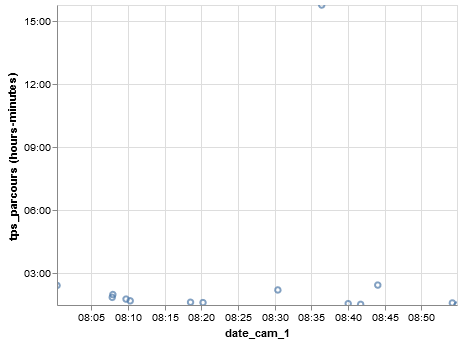

In [159]:
df_transit2=test.df_transit[['date_cam_1', 'tps_parcours']].copy().reset_index().drop('index', axis=1)
graph_tps_bruts = alt.Chart(df_transit2).mark_point().encode(
                        x='date_cam_1',
                        y='hoursminutes(tps_parcours)',
                        tooltip='tps_parcours').interactive()
temps_int=((pd.to_datetime('2018-01-01')+df_transit2['tps_parcours'])-pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')#convertir les temps en integer
#mise en forme des données pour passer dans sklearn 
donnnes = temps_int.values
matrice=donnnes.reshape(-1, 1)
#faire tourner la clusterisation et recupérer le label (i.e l'identifiant cluster) et le nombre de cluster
clustering=DBSCAN(eps=600, min_samples=len(temps_int)/2).fit(matrice)
labels = clustering.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# A AMELIORER EN CREANT UNE ERREUR PERSONALISEE SI ON OBTIENT  CLUSTER
"""if n_clusters_== 0 :
    raise ClusterError()"""
#mettre en forme au format pandas
results = pd.DataFrame(pd.DataFrame([df_transit2.index,labels]).T)
results.columns = ['index_base', 'cluster_num']
results = pd.merge(results,df_transit2, left_on='index_base', right_index=True )
#obtenir un timedelta unique
temp_parcours_max=results.loc[results.loc[:,'cluster_num']!=-1].groupby(['cluster_num'])['tps_parcours'].max()
#temp_parcours_max=pd.to_timedelta(temp_parcours_max.values[0])
df_transit2.tps_parcours=pd.to_datetime('2018-01-01')+df_transit2.tps_parcours
graph_tps_bruts

In [160]:
temp_parcours_max

cluster_num
0   01:47:42
Name: tps_parcours, dtype: timedelta64[ns]

In [207]:
%%time
cameras_suivantes=[12,6,3,18,13]
dico_traj_directs={}
for indice,couple_cam in enumerate([[cameras_suivantes[i],cameras_suivantes[i+1]] for i in range(len(cameras_suivantes)-1)]) :
    nom_variable='trajet'+str(indice)
    print (indice, dt.datetime.now())
    if indice==0 : # si c'est le premier tarjet on se base sur des paramètres classiques
        trajet=t.trajet_direct(df_journee, '2019-01-29 08:00:00', 60, 16, couple_cam[0], couple_cam[1])
    else : 
        cle_traj_prec='trajet'+str(indice-1)
        print (indice, dt.datetime.now())
        trajet=(t.trajet_direct(df_journee, dico_traj_directs[cle_traj_prec].timestamp_mini,
                                     60,16,
                                     couple_cam[0], couple_cam[1]))
        print (indice,dico_traj_directs[cle_traj_prec].duree_traj_fut, dt.datetime.now())
    dico_traj_directs[nom_variable]=trajet

0 2019-04-02 15:44:55.092174
1 2019-04-02 15:44:55.560839
1 2019-04-02 15:44:55.560839
1 73 2019-04-02 15:44:56.216941
2 2019-04-02 15:44:56.216941
2 2019-04-02 15:44:56.216941
2 73 2019-04-02 15:44:56.888625
3 2019-04-02 15:44:56.888625
3 2019-04-02 15:44:56.888625
3 75 2019-04-02 15:44:57.435400
Wall time: 2.34 s
